In [3]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

def import_sys():
    import sys
    sys.path.append('..')
import_sys()

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)  # pylint: disable=invalid-name

In [4]:
import errudite
print(errudite)

<module 'errudite' from '/Users/gyuhoshim/errudite/errudite/__init__.py'>


In [5]:
import pandas as pd
from tqdm import tqdm

from overrides import overrides

from errudite.io import DatasetReader
from errudite.utils import normalize_file_path, accuracy_score
from errudite.targets.instance import Instance
from errudite.targets.target import Target
from errudite.targets.label import Label, PredefinedLabel

In [7]:
#!pip install transformers==4.3.0

In [8]:
#!pip install sentencepiece

In [9]:
#!pip install accelerate

In [10]:
#!pip install  xlrd==1.1.0

In [11]:
#!pip install --upgrade ipywidgets

In [12]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from typing import List, Dict
import sys
sys.path.append('..')
from errudite.predictors.predictor import Predictor
from errudite.targets.label import Label, PredefinedLabel

class Predictor_FLAN_T5(Predictor):
    def __init__(self, name: str, 
    model_path: str=None,
    model_online_path: str=None,
    description: str='',
    model_type: str=None) -> None:
        model = None
        Predictor.__init__(self, name, description, model, ['accuracy', 'accuracy_PE', 'accuracy_KE', 'accuracy_LCE'])
        
    def predict_essay(self, essay : str) -> Dict[str,str]:
        # Load data into pandas DataFrame
        data_df = pd.read_excel("StudentEssays.xlsx")

        # Initialize T5 tokenizer and model
        tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
        model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

        # Move the model to the CUDA device if available
        if torch.cuda.is_available():
            model.to("cuda")

        # Define a list of concepts to predict
        concepts_to_predict = ["potential energy", "kinetic energy", "Law of Conservation of Energy"]

        # Define possible outcome labels
        outcome_labels = ["Acceptable", "Unacceptable", "Insufficient", "Not Found"]

        # Create a list to store predictions as dictionaries
        predictions_list = []

        text = essay  # Assuming the text content is in column 'Essay'

        # Initialize predictions dictionary for this row
        predictions = {}

        # Iterate through each concept to predict
        for concept in concepts_to_predict:
            # Define a template for classification
            template = f"According to the following essay, is the student's definition of {concept} Acceptable, Unacceptable, Insufficient, or Not Found? Only use one of these labels for outputs\n{text}"
            # Prepare the input by replacing placeholders
            formatted_input = template
            # Tokenize and classify the text
            input_ids = tokenizer(formatted_input, return_tensors="pt", padding=True, truncation=True).input_ids.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model.generate(input_ids, max_length=128)
            decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)  # Remove special tokens

            # Store the prediction in the dictionary
            predictions[concept] = next((label for label in outcome_labels if label.lower() in decoded_output.lower()), "Unknown")

            if predictions[concept] == "Unknown":
              print(len(decoded_output))
              with open('output.txt', 'w') as f:
                f.write(decoded_output)

        return predictions

INFO:pytorch_pretrained_bert.modeling:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:pytorch_transformers.modeling_bert:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:pytorch_transformers.modeling_xlnet:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>


## 1. DatasetReader

In [13]:
@DatasetReader.register("STE")
class STEReader(DatasetReader):
    def __init__(self, cache_folder_path: str=None) -> None:
        super().__init__(cache_folder_path)
        # overwrite the primary evaluation method and metric name
        Label.set_task_evaluator(accuracy_score, 'accuracy')
        
    @overrides
    def _read(self, file_path: str, lazy: bool, sample_size: int):
        """
        Returns a list containing all the instances in the specified dataset.
 
        Parameters
        ----------
        file_path : str
            The path of the input data file.
        lazy : bool, optional
            If ``lazy==True``, only run the tokenization, does not compute the linguistic
            features like POS, NER. By default False
        sample_size : int, optional
            If sample size is set, only load this many of instances, by default None
        
        Returns
        -------
        List[Instance]
            The instance list.
        """
        instances = []
        essays = []
        logger.info("Reading instances from lines in file at: %s", file_path)
        df = pd.read_excel(normalize_file_path(file_path), sep='\t')
        for idx, row in tqdm(df.iterrows()):
            if lazy:
                essays.append(row['Essay'])
            else:
                instance = self._text_to_instance(f'q:{idx}', row)
                if instance is not None:
                    instances.append(instance)
                if sample_size and idx > sample_size:
                    break
        if lazy:
            return { "Essays": essays }
        else:
            return instances
    
    @overrides
    def _text_to_instance(self, id: str, row) -> Instance:
        # The function that transfers raw text to instance.
        essay = Target(qid=row['Essay_ID'], text=row['Essay'], vid=0, metas={'type': 'essays'})        # label
        groundtruth_PE = PredefinedLabel(
            model='groundtruth', 
            qid=row['Essay_ID'], 
            text=row['PE'], 
            vid=0, 
        )
        groundtruth_KE = PredefinedLabel(
            model='groundtruth', 
            qid=row['Essay_ID'], 
            text=row['KE'], 
            vid=0, 
        )
        groundtruth_LCE = PredefinedLabel(
            model='groundtruth', 
            qid=row['Essay_ID'], 
            text=row['LCE'], 
            vid=0, 
        )
        return self.create_instance(row['Essay_ID'], 
            essay=essay, 
            groundtruth_PE=groundtruth_PE,
            groundtruth_KE=groundtruth_KE,
            groundtruth_LCE=groundtruth_LCE)

In [14]:
from errudite.io import DatasetReader

cache_folder_path = "./ste_caches"
reader = DatasetReader.by_name("STE")(cache_folder_path=cache_folder_path)

INFO:errudite.utils.file_utils:Errudite cache folder selected: ./ste_caches


## 2. Predictor

In [15]:
from typing import List, Dict
import sys
sys.path.append('..')
from errudite.predictors.predictor import Predictor
from errudite.targets.label import Label, PredefinedLabel

In [16]:
@Predictor.register("STE_FLAN_T5")
class PredictorSTE(Predictor_FLAN_T5):
    def __init__(self, name: str, 
        model_path: str=None,
        model_online_path: str=None,
        description: str='') -> None:
        Predictor_FLAN_T5.__init__(self, name, model_path, model_online_path, description)
        import sys
        sys.path.append('..')
        from errudite.utils.evaluator import accuracy_score
        # Second, from the metrics above, pick one that's primary, and it will be used 
        # to compute `is_incorrect()` in any label target object: primary metric < 1.
        Label.set_task_evaluator(
            # the evaluation function that accepts pred and groundtruths, 
            # and return a dict of metrics: { metric_name: metric_score }. 
            # This is saved as Label.task_evaluation_func.
            task_evaluation_func=accuracy_score, 
            # The primary task metric name, ideally a key of task_evaluation_func ‘s return.
            task_primary_metric='accuracy')

    # the raw prediction function, returning the output of the model in a json format.
    def predict(self, essay: str) -> Dict[str, str]:
        predicted = self.predict_essay(essay)
        return predicted

    @classmethod
    # the class method that takes `Target` inputs, and output a `Label` object.
    def model_predict(cls, 
        predictor: Predictor, 
        essay: Target, 
        groundtruth_PE: Label, groundtruth_KE: Label, groundtruth_LCE: Label) -> 'Label':
        answer = None
        if not predictor:
            return answer
        predicted = predictor.predict(essay.get_text())
        if not predicted:
            return None
        answer_PE = PredefinedLabel(
            model=predictor.name, 
            qid=essay.qid,
            text=predicted['potential energy'], 
            vid=max([essay.vid]))
        answer_KE = PredefinedLabel(
            model=predictor.name, 
            qid=essay.qid,
            text=predicted['kinetic energy'], 
            vid=max([essay.vid]))
        answer_LCE = PredefinedLabel(
            model=predictor.name, 
            qid=essay.qid,
            text=predicted['Law of Conservation of Energy'], 
            vid=max([essay.vid]))
        answer_PE.compute_perform(groundtruths=groundtruth_PE)
        answer_KE.compute_perform(groundtruths=groundtruth_KE)
        answer_LCE.compute_perform(groundtruths=groundtruth_LCE)
        return answer_PE, answer_KE, answer_LCE



In [17]:
# read the raw data!
instances = reader.read(
    # The path of the input data file. We are using the first 100 rows from the SNLI dev set.
    file_path='StudentEssays.xlsx', 
    # If sample size is set, only load this many of instances, by default None.
    sample_size=76)

INFO:errudite.io.dataset_reader:Reading instances from lines in file at: StudentEssays.xlsx
INFO:__main__:Reading instances from lines in file at: StudentEssays.xlsx
76it [00:02, 30.71it/s]


In [18]:
from errudite.predictors import Predictor
model_path = "FLAN_T5_Essay"
predictor = Predictor.by_name("STE_FLAN_T5")(
    name ='FLAN_T5', 
    description='Prediction created by FLAN_T5')

In [19]:
from tqdm import tqdm 
logger.info("Running predictions....") 
for instance in tqdm(instances):
    prediction_PE, prediction_KE, prediction_LCE = Predictor.by_name("STE_FLAN_T5").model_predict(
        predictor, 
        essay = instance.essay,
        groundtruth_PE = instance.groundtruth_PE, groundtruth_KE = instance.groundtruth_KE, groundtruth_LCE = instance.groundtruth_LCE)
    # set the prediction
    instance.set_entries(prediction_PE = prediction_PE, prediction_KE = prediction_KE, prediction_LCE = prediction_LCE)

INFO:__main__:Running predictions....
100%|██████████| 76/76 [12:26<00:00,  9.17s/it]


In [20]:
print(instances[2].get_entry('essay'), "\n")
instances[2].show_instance()

[Target] [InstanceKey(qid='L23-RCFinal proposal, L22-RCFinal proposal, L3b8-22_RCFinal proposal, L3b8-20_RCFinal proposal, & L3b8-19_RCFinal', vid=0)]
The initial drop must be the highest point of your roller coaster. It will be where all of the energy must be created in the form of Potential energy. A height of 90m would be just right because the initial drop can help the car to go over the hills with enough potential energy. I propose that we should make the roller coasters drop 90 meters tall because the roller coaster needs a lot of KE to go through the rest of the roller coaster. During initial drop, the increasing height increases potential energy at the top of hill and kinetic energy at the bottom of hill. When we increase the initial drop height the car has a faster speed so it'll be able to travel farther.

The hill of the roller coaster is another critical part. It must be a smaller height than the initial drop to have enough energy to go up the hill. The hill can be .80 mete

In [21]:
predictor.evaluate_performance(instances)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.039473684210526314, 'accuracy_PE': 0.5526315789473685, 'accuracy_KE': 0.39473684210526316, 'accuracy_LCE': 0.2631578947368421}}


In [22]:
# ---------
# Build the instance store hash
from errudite.targets.instance import Instance
instance_hash, instance_hash_rewritten, qid_hash = Instance.build_instance_hashes(instances)

In [23]:
print(instances[2].is_incorrect(model = 'FLAN_T5'), "\n")

True 



In [24]:
from errudite.builts import Group
from errudite.builts import Attribute
group_length_100 = Group.create(
    # The name of the attribute
    name="length",
    # the description of the attribute
    description="length greater than 100",
    # All the previously created attributes and groups 
    # can be used and queried, as long as we serve the 
    # stored attributes and groups as part of the inputs.
    cmd="length(essay) > 100",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[FuncOp(length):[ArgOp:essay]+[], 100.0]
INFO:errudite.builts.group:Created group: length


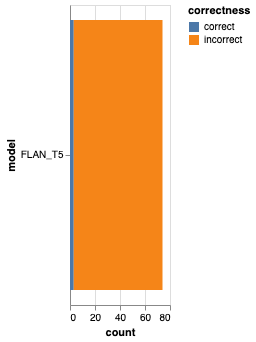

In [25]:
group_length_100.visualize_models(models=["FLAN_T5"])

In [26]:
# some general stats on groups
Group.eval_stats(
    filtered_instances=group_length_100.get_instances(),
    # this will automatically call the default model we got
    model=None
)

{'counts': {'correct': 3, 'incorrect': 71},
 'stats': {'coverage': 0.9736842105263158,
  'error_coverage': 0.9726027397260274,
  'local_error_rate': 0.9594594594594594,
  'global_error_rate': 0.9342105263157895}}

In [27]:
from errudite.builts import Group
from errudite.builts import Attribute
group_length_200 = Group.create(
    # The name of the attribute
    name="length",
    # the description of the attribute
    description="length greater than 200",
    # All the previously created attributes and groups 
    # can be used and queried, as long as we serve the 
    # stored attributes and groups as part of the inputs.
    cmd="length(essay) > 200",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[FuncOp(length):[ArgOp:essay]+[], 200.0]
INFO:errudite.builts.group:Created group: length


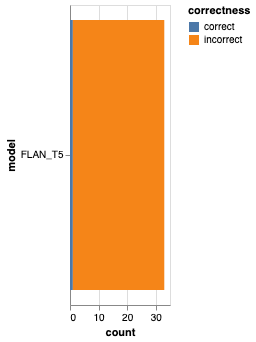

In [28]:
group_length_200.visualize_models(models=["FLAN_T5"])

In [29]:
# some general stats on groups
Group.eval_stats(
    filtered_instances=group_length_200.get_instances(),
    # this will automatically call the default model we got
    model=None
)

{'counts': {'correct': 1, 'incorrect': 32},
 'stats': {'coverage': 0.4342105263157895,
  'error_coverage': 0.4383561643835616,
  'local_error_rate': 0.9696969696969697,
  'global_error_rate': 0.42105263157894735}}

In [39]:
from errudite.rewrites import Rewrite
rewrite = Rewrite.create_with_cmd(
    from_cmd='rest', 
    to_cmd= 'motion', 
    target_cmd= 'essay'
)

INFO:errudite.build_blocks.wrapper:Parsed: essay
INFO:errudite.build_blocks.wrapper:Parsed: essay


<class 'errudite.rewrites.replace_str.ReplaceStr'>


In [41]:
# rewrite.pattern

In [40]:
from errudite.targets.instance import Instance
from errudite.targets.target import Target
from tqdm import tqdm

for key in tqdm(group_length_100.get_instances()):
    """
    This function returns a named tuple, with rid and the 
    rewritten text of the instance intended target. 
    If the instance cannot be rewritten, return None.
    """
    instance = Instance.get(key)
    rewritten_output = rewrite.rewrite_one_instance(instance)
    if not rewritten_output:
        continue
    entries = {}
    # compute the vid automatically
    vid = len(Instance.qid_hash[instance.qid])
    # init the instance 
    rewritten_instance = Instance(
        qid=instance.qid, vid=vid, rid=rewrite.rid)
    for e in instance.entries:
        if e in rewrite.target_cmd:
            # automatically create a new Target for the 
            # rewritten part.
            entry = Target(
                qid=instance.qid, 
                text=rewritten_output.text, 
                vid=vid, 
                metas=instance.get_entry(e).metas)
        else:
            # Otherwise, use the original target
            entry = instance.get_entry(e)
        # save all the entries
        rewritten_instance.set_entries(**{e: entry})
    # run the prediction
    prediction_PE, prediction_KE, prediction_LCE = Predictor.by_name("STE_FLAN_T5").model_predict(
        predictor, 
        essay = rewritten_instance.get_entry('essay'),
        groundtruth_PE = instance.groundtruth_PE, groundtruth_KE = instance.groundtruth_KE, groundtruth_LCE = instance.groundtruth_LCE)
    # save the prediction
    rewritten_instance.set_entries(prediction_PE = prediction_PE, prediction_KE = prediction_KE, prediction_LCE = prediction_LCE)
    # set the rewritten key into the rewrite
    rewrite.add_instance(rewritten_instance.key())
    # save into the Instance hashes
    Instance.save(rewritten_instance)

100%|██████████| 74/74 [01:34<00:00,  2.15s/it]


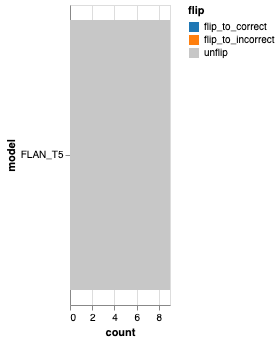

In [42]:
rewrite.visualize_models(models=["FLAN_T5"])

In [43]:
from errudite.rewrites import Rewrite
Rewrite.eval_stats(rewrite,qids=None)

{'counts': {'rewritten': 9,
  'prediction_changed': 1,
  'flips': {'flip_to_correct': 0, 'flip_to_incorrect': 0, 'unflip': 9}},
 'stats': {'coverage': 0.11842105263157894,
  'changed_coverage': 0.013157894736842105,
  'changed_rate': 0.1111111111111111}}

In [44]:
from errudite.rewrites import Rewrite
rewrite = Rewrite.create_with_cmd(
    from_cmd='top', 
    to_cmd= 'bottom', 
    target_cmd= 'essay'
)

INFO:errudite.build_blocks.wrapper:Parsed: essay
INFO:errudite.build_blocks.wrapper:Parsed: essay


<class 'errudite.rewrites.replace_str.ReplaceStr'>


In [ ]:
from errudite.targets.instance import Instance
from errudite.targets.target import Target
from tqdm import tqdm

for key in tqdm(group_length_100.get_instances()):
    """
    This function returns a named tuple, with rid and the 
    rewritten text of the instance intended target. 
    If the instance cannot be rewritten, return None.
    """
    instance = Instance.get(key)
    rewritten_output = rewrite.rewrite_one_instance(instance)
    if not rewritten_output:
        continue
    entries = {}
    # compute the vid automatically
    vid = len(Instance.qid_hash[instance.qid])
    # init the instance 
    rewritten_instance = Instance(
        qid=instance.qid, vid=vid, rid=rewrite.rid)
    for e in instance.entries:
        if e in rewrite.target_cmd:
            # automatically create a new Target for the 
            # rewritten part.
            entry = Target(
                qid=instance.qid, 
                text=rewritten_output.text, 
                vid=vid, 
                metas=instance.get_entry(e).metas)
        else:
            # Otherwise, use the original target
            entry = instance.get_entry(e)
        # save all the entries
        rewritten_instance.set_entries(**{e: entry})
    # run the prediction
    prediction_PE, prediction_KE, prediction_LCE = Predictor.by_name("STE_FLAN_T5").model_predict(
        predictor, 
        essay = rewritten_instance.get_entry('essay'),
        groundtruth_PE = instance.groundtruth_PE, groundtruth_KE = instance.groundtruth_KE, groundtruth_LCE = instance.groundtruth_LCE)
    # save the prediction
    rewritten_instance.set_entries(prediction_PE = prediction_PE, prediction_KE = prediction_KE, prediction_LCE = prediction_LCE)
    # set the rewritten key into the rewrite
    rewrite.add_instance(rewritten_instance.key())
    # save into the Instance hashes
    Instance.save(rewritten_instance)

 36%|███▋      | 27/74 [03:26<06:50,  8.73s/it]

In [ ]:
rewrite.visualize_models(models=["FLAN_T5"])

In [ ]:
from errudite.rewrites import Rewrite
Rewrite.eval_stats(rewrite,qids=None)

In [30]:
import traceback
from typing import Union, List
from spacy.tokens import Doc, Span, Token
def import_sys():
    import sys
    sys.path.append('..')
import_sys()
from errudite.utils.helpers import convert_doc
from errudite.utils.check import DSLValueError
import logging
logger = logging.getLogger(__name__)  # pylint: disable=invalid-name


In [31]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import linguistic

@PrimFunc.register()
def location(docs: Union['Target', Span]) -> bool:
    """
    Detect the presence of location entities ('bottom' or 'top') in the essay.
    """
    # Use the linguistic function to extract entity types
    entities = linguistic(docs, label='ent_type')
    #print(entities)
    contains='QUANTITY' in entities# or 'top' in entities
    # Check if 'bottom' or 'top' is present in the extracted entity types
    #print(contains)
    return contains


In [32]:
from errudite.builts import Attribute, Group

# Create an attribute based on the location function
attr = Attribute.create(
    name="location_entities",
    description="Presence of location entities in the essay",
    cmd="location(essay)"
)

# Create a group that checks for the presence of location entities
group = Group.create(
    name="location",
    description="Location entity detected",
    cmd="attr:location_entities == TRUE",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)


INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(location):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: location_entities
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](==):[[BuildBlockOp](attr):location_entities, True]
INFO:errudite.builts.group:Created group: location


<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class '

In [33]:
# some general stats on groups
Group.eval_stats(
    filtered_instances=group.get_instances(),
    # this will automatically call the default model we got
    model=None
)

{'counts': {'correct': 0, 'incorrect': 49},
 'stats': {'coverage': 0.6447368421052632,
  'error_coverage': 0.6712328767123288,
  'local_error_rate': 1.0,
  'global_error_rate': 0.6447368421052632}}

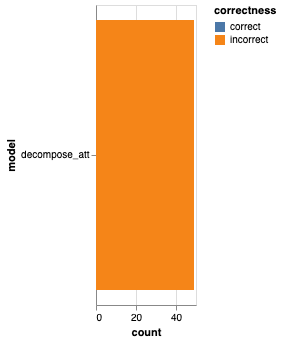

In [34]:
group.visualize_models(models=["decompose_att"])

In [35]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import linguistic
import spacy

nlp = spacy.load("en_core_web_sm")  # Load the SpaCy English model

@PrimFunc.register()#def num_adjectives(docs: spacy.tokens.Doc) -> int:
def num_adjectives(docs: Union['Target', Span])->int:
    """
    Count the number of adjectives in a given document.
    """
    try:
        adjectives = [token for token in docs if token.pos_ == "ADJ"]
        return len(adjectives)
    except Exception as e:
        ex = Exception(f"Unknown exception from [num_adjectives]: {e}")
        raise ex

# # Sample usage
# essay_text = "This is a beautiful and interesting essay about natural language processing."
# doc = nlp(essay_text)
# num_of_adjectives = num_adjectives(doc)
# print(f"Number of adjectives in the essay: {num_of_adjectives}")


In [36]:
from errudite.builts import Attribute, Group

# Assuming you have already defined the PrimFunc num_adjectives

# Create an attribute that counts the adjectives among essay targets
attr = Attribute.create(
    name="num_adjectives_in_essay",
    description="Number of adjectives among essay targets",
    cmd="num_adjectives(essay)"
)

# Create a group to check if there are more than 5 adjectives in the essay
group = Group.create(
    name="adjective_count_group",
    description="Group for counting adjectives in the essay",
    cmd="attr:num_adjectives_in_essay > 5",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

# You can now use the 'group' to check if there are more than 5 adjectives in your essay targets.


INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(num_adjectives):[ArgOp:essay]+[]
ERROR:errudite.build_blocks.wrapper:Unknown exception from [ test_instances ]: Unknown exception from [num_adjectives]: 'Target' object is not iterable


Exception: Unknown exception from [num_adjectives]: 'Target' object is not iterable

In [ ]:
# some general stats on groups
Group.eval_stats(
    filtered_instances=group.get_instances(),
    # this will automatically call the default model we got
    model=None
)

In [ ]:
group.visualize_models(models=["decompose_att"])